In [1]:
import pandas as pd

In [2]:
data_dir = '/home/vadim/playlist_generation/data/random_data'

In [3]:
tracks = pd.read_csv('{}/tracks.csv'.format(data_dir), index_col=0)
artists = pd.read_csv('{}/artists.csv'.format(data_dir), index_col=0)
albums = pd.read_csv('{}/albums.csv'.format(data_dir), index_col=0)
transactions = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
playlists = pd.read_csv('{}/playlists.csv'.format(data_dir), index_col=0)

In [4]:
def get_full_dataset(transactions, tracks, playlists):
    full_dataset = pd.merge(transactions, tracks, how='left', on='trackid')
    full_dataset = pd.merge(full_dataset, playlists, how='left', on='pid')
    return full_dataset

In [5]:
full_dataset = get_full_dataset(transactions, tracks, playlists)
full_dataset['rating'] = 1
full_dataset.head()

,pid,trackid,popular,artistid,albumid,name,num_followers,rating
0,822032,2283,3384,1151,1618,party time,1,1
1,822032,2288,4339,1152,1622,party time,1,1
2,822032,907,4992,500,687,party time,1,1
3,822032,2289,1822,503,690,party time,1,1
4,822032,910,2160,503,690,party time,1,1


In [6]:
from polara.recommender.models import RecommenderModel
from polara.recommender.data import RecommenderData
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy import sparse
from polara.recommender.coldstart.data import ItemColdStartData

In [7]:
class LocalCollectiveEmbeddings(RecommenderModel):
    import scipy.sparse
    
    def __init__(self, *args, **kwargs):
        super(LocalCollectiveEmbeddings, self).__init__(*args, **kwargs)
        self.method = 'LCE'
    
    def get_train_content(self, content_data):
        self.train_content = content_data
    
    def get_content_shape(self):
        self.content_shape = {}
        for col in self.train_content.columns:
            self.content_shape[col] = self.train_content[col].max() + 1

    def get_training_content_matrix(self):
        self.get_content_shape()
        idx_userid = self.data.training[self.data.fields[0]].values
        val = np.ones(self.data.training.shape[0])
        
        i = 0
        user_cat_features = []
        
        for col in self.train_content.columns:
            idx_feature = self.train_content[col].values
            shp = (idx_userid.max() + 1, 
                   self.content_shape[col])
        
            user_cat_features_new = sparse.csr_matrix((val, (idx_userid, idx_feature)), 
                                    shape=shp)
            
            if i == 0:
                user_cat_features = user_cat_features_new
            else:
                user_cat_features = sparse.hstack((user_cat_features, user_cat_features_new))
            
            i += 1
        
        return user_cat_features
    
    def get_test_content_matrix(self):
        self.get_content_shape()
        idx_userid = self.data.test.testset[self.data.fields[0]].values
        val = np.ones(self.data.test.testset.shape[0])
        
        i = 0
        user_cat_features = []
        
        for col in self.train_content.columns:
            idx_feature = self.data.test.testset[col].values
            shp = (idx_userid.max() + 1, 
                   self.content_shape[col])
        
            user_cat_features_new = sparse.csr_matrix((val, (idx_userid, idx_feature)), 
                                       shape=shp)
            
            if i == 0:
                user_cat_features = user_cat_features_new
            else:
                user_cat_features = sparse.hstack((user_cat_features, user_cat_features_new))
            
            i += 1
        
        
        return user_cat_features
        
        
    def construct_closeness_matrix(self, X, k=15, binary=False):
        print ('Construct closeness matrix...')
        nbrs = NearestNeighbors(n_neighbors=1 + k).fit(X)
        if binary:
            closeness_matrix = nbrs.kneighbors_graph(X)
        else:
            closeness_matrix = nbrs.kneighbors_graph(X, mode='distance')
        print ('Done.')
            
        return closeness_matrix
    
    def get_constant(self, user_item_matrix, user_cat_features):
        trRtR = tr(user_item_matrix, user_item_matrix)
        trXutXu = tr(user_cat_features, user_cat_features)
        return trRtR, trXutXu
    
    def get_variable(self, user_item_matrix, 
                     user_cat_features, user_factors, 
                     item_factors, feature_factors, 
                     closeness_matrix, D):
        UtU = user_factors.T.dot(user_factors)
        UtR = user_factors.T.dot(user_item_matrix)
        UtXu = user_factors.T.dot(user_cat_features)
        UtUV = UtU.dot(item_factors)
        UtUHu = UtU.dot(feature_factors)
        DU = D.dot(user_factors)
        AU = closeness_matrix.dot(user_factors)
        
        return (UtU, UtR, UtXu,
                UtUV, UtUHu, 
                DU, AU)
        
    def build(self, content_data, 
              rank=10, alpha=0.1, beta=0.05, lamb=0.001, 
              epsilon=0.01, maxiter=150, verbose=True):
        
        self.get_train_content(content_data)
        
        user_item_matrix = self.get_training_matrix(dtype='float64')
        user_cat_features = self.get_training_content_matrix()
        closeness_matrix = self.construct_closeness_matrix(user_cat_features, 
                                                           rank, binary=True)
        
        num_users = user_item_matrix.shape[0]
        num_items = user_item_matrix.shape[1]
        num_features = user_cat_features.shape[1]
        
        user_factors = np.abs(sparse.rand(num_users, rank, 0.5, 'csr', 
                                          dtype=user_item_matrix.dtype))
        item_factors = np.abs(sparse.rand(rank, num_items, 0.5, 'csr', 
                                          dtype=user_item_matrix.dtype))
        feature_factors = np.abs(sparse.rand(rank, num_features, 0.5, 'csr', 
                                             dtype=user_item_matrix.dtype))
        
        
        #auxiliary constant and variable   
        
        
        D = sparse.dia_matrix((closeness_matrix.sum(axis=0), 0), 
                                                   closeness_matrix.shape)
        gamma = 1. - alpha
        
        trRtR, trXutXu = self.get_constant(user_item_matrix, user_cat_features)
        (UtU, UtR, UtXu,
         UtUV, UtUHu, DU, AU) = self.get_variable(user_item_matrix, 
                                                  user_cat_features, user_factors, 
                                                  item_factors, feature_factors, 
                                                  closeness_matrix, D) 

        itNum = 1
        delta = 2.0 * epsilon

        ObjHist = []

        while True:
            
            # update item_factors
            item_factors_1 = np.divide(
                (alpha * UtR), (alpha * UtUV + lamb * item_factors).maximum(1e-10))
    
            item_factors = item_factors.multiply(item_factors_1)
            
            #update feature_factors
            feature_factors_1 = np.divide(
                (gamma * UtXu), (gamma * UtUHu + lamb * feature_factors).maximum(1e-10))
            feature_factors = feature_factors.multiply(feature_factors_1)
            
            # update user_factors
            user_factors_t1 = alpha * user_item_matrix.dot(item_factors.T) + \
            gamma * user_cat_features.dot(feature_factors.T) + beta * AU
            
            user_factors_t2 = alpha * user_factors.dot(item_factors.dot(item_factors.T)) + gamma * \
            user_factors.dot(feature_factors.dot(feature_factors.T)) + beta * DU + lamb * user_factors
            
            user_factors_t3 = np.divide(user_factors_t1, (user_factors_t2).maximum(1e-10))
            user_factors = user_factors.multiply(user_factors_t3)

            # calculate objective function
            (UtU, UtR, UtXu,
             UtUV, UtUHu, DU, AU) = self.get_variable(user_item_matrix, 
                                                      user_cat_features, user_factors, 
                                                      item_factors, feature_factors, 
                                                      closeness_matrix, D)

            tr1 = alpha * (trRtR - 2. * tr(item_factors, UtR) + tr(item_factors, UtUV))
            tr2 = gamma * (trXutXu - 2. * tr(feature_factors, UtXu) + tr(feature_factors, UtUHu))
            tr3 = beta * (tr(user_factors, DU) - tr(user_factors, AU))
            tr4 = lamb * (UtU.diagonal().sum() + tr(item_factors, item_factors) + \
                          tr(feature_factors, feature_factors))

            Obj = tr1 + tr2 + tr3 + tr4
            ObjHist.append(Obj)

            if itNum > 1:
                delta = abs(ObjHist[-1] - ObjHist[-2])
                if verbose:
                    print ("Iteration: ", itNum, "Objective: ", Obj, "Delta: ", delta)
                if itNum > maxiter or delta < epsilon:
                    break

            itNum += 1
            
        self.user_factors = user_factors
        self.feature_factors = feature_factors 
        self.item_factors = item_factors
        
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        slice_data = self._slice_test_data(test_data, start, stop)
        user_cat_features = self.get_test_content_matrix()
        Ut = np.linalg.lstsq(self.feature_factors.T.toarray(), 
                             user_cat_features.T.toarray(), rcond=-1)[0]
        R = Ut.T.dot(self.item_factors.toarray())
        return R, slice_data

In [8]:
def reindex_content(content_data, col, sort=True, inplace=True):
    grouper = content_data.groupby(col, sort=sort).grouper
    new_val = grouper.group_info[1]
    old_val = grouper.levels[0]
    val_transform = pd.DataFrame({'old': old_val, 'new': new_val})
    new_data = grouper.group_info[0]

    if inplace:
        result = val_transform
        content_data.loc[:, col] = new_data
    else:
        result = (new_data, val_transform)
    return result
        
def reindex_content_columns(content_data, columns):
    index_content = {}
    for col in columns:
        index_content[col] = reindex_content(content_data, col)
    return index_content

In [9]:
def tr(A, B):
    x = A.multiply(B)
    return (x.sum(axis=0)).sum(axis=1)

In [14]:
def cross_validation_lce(data, n_splits=5, seed=1, test_size=0.05, topk=500, rank=10):
    
    index_content = reindex_content_columns(data, ['artistid', 'albumid'])
    
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        train_albums = train.albumid.unique()
        train_artists = train.artistid.unique()
        test = test.query('albumid in @train_albums')
        test = test.query('artistid in @train_artists')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        lce = LocalCollectiveEmbeddings(data_model)
        lce.build(train[['artistid', 'albumid']], verbose=False, rank=rank, maxiter=150)
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        lce.topk = topk
        lce.swith_positive = 1
        print (lce.swith_positive)
        hits = lce.evaluate()
        relevance = lce.evaluate('relevance')
        ranking = lce.evaluate('ranking')
        
        scores['precision'].append(relevance.precision)
        scores['recall'].append(relevance.recall)
        scores['miss_rate'].append(relevance.miss_rate)
        scores['nDCG'].append(ranking.nDCG)
        
        print (hits)
        
    result = pd.DataFrame(scores)
    return result

In [15]:
import tqdm

In [16]:
ranks = [5,10]
recall = []
nDCG = []
precision = []
miss_rate = []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    result = cross_validation_lce(full_dataset, topk=10, test_size=0.1, rank=rank)
    recall.append(result.recall.mean())
    nDCG.append(result.nDCG.mean())
    precision.append(result.precision.mean())
    miss_rate.append(result.miss_rate.mean())


  0%|          | 0/2 [00:00<?, ?it/s]

             ===========rank=5=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
1
Hits(true_positive=155, false_positive=12025, true_negative=None, false_negative=4071)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
1
Hits(true_positive=104, false_positive=11936, true_negative=None, false_negative=3976)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
98 unique trackid's wit

 50%|█████     | 1/2 [01:27<01:27, 87.92s/it]

Hits(true_positive=115, false_positive=12035, true_negative=None, false_negative=4042)
             ===========rank=10=============
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
1
Hits(true_positive=187, false_positive=11993, true_negative=None, false_negative=4039)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsi

100%|██████████| 2/2 [03:51<00:00, 115.52s/it]

Hits(true_positive=214, false_positive=11936, true_negative=None, false_negative=3943)


In [17]:
import matplotlib.pyplot as plt

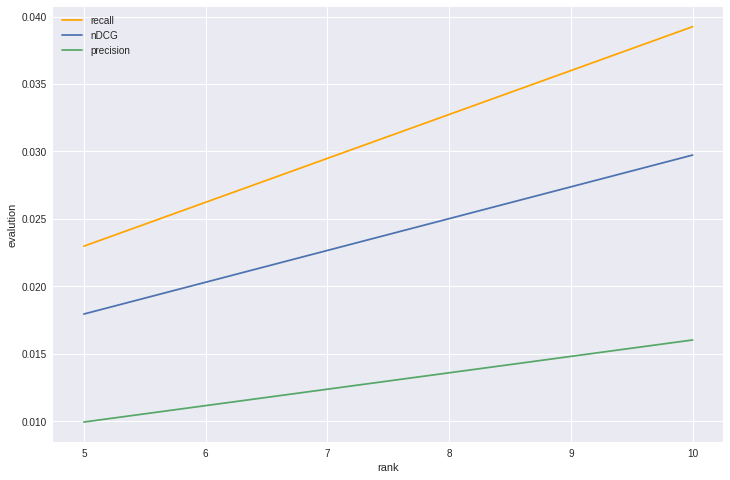

In [18]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall, 'orange', label='recall')
plt.plot(ranks, nDCG,label='nDCG')
plt.plot(ranks, precision, label='precision')
#plt.plot(ranks, miss_rate, label='miss_rate')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()

In [19]:
%time cross_validation_lce(full_dataset, test_size=0.1, topk=10, rank=10)

=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
1
Hits(true_positive=208, false_positive=11972, true_negative=None, false_negative=4018)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
1
Hits(true_positive=176, false_positive=11864, true_negative=None, false_negative=3904)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.
98 unique trackid's wit

,miss_rate,nDCG,precision,recall
0,0.957803,0.030297,0.017077,0.042197
1,0.967462,0.026581,0.014618,0.032538
2,0.961882,0.028861,0.016476,0.038118
3,0.968231,0.025334,0.013534,0.031769
4,0.960770,0.031330,0.017202,0.039230
